# Simple Neural Network Model with different number of months

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, calculate_metrics, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [4]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

Preparing outputs common for all models

In [5]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [6]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

Cannot get optimal portfolio for 2022-05-06 00:00:00
Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-03-03 00:00:00
Cannot get optimal portfolio for 2023-05-04 00:00:00


(288, 27)

In [7]:
val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:val_split]
y_train = y[:val_split]

# Validation
dates_for_validation = days_to_recalculate[val_split:test_split]
y_val = y[val_split:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
y_test = y[test_split:]

In [8]:
os.chdir(os.path.expanduser('../data'))

In [9]:
df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

## Cross validation to calculate optimal number of months

In [10]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'DNN Model for {no_months} months')
    x = []
    for date in days_to_recalculate:
        indicators = data_provider.calculate_principal_component_from_indicators(
            date, periods=no_months, indicators=all_indicators)
        x.append(indicators.values)

    x_pca = np.array(x)
    x_train = x_pca[:val_split]
    x_val = x_pca[val_split:test_split]
    x_test = x_pca[test_split:]

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Flatten(input_shape=x_train.shape[1:]),
            Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation,
            df_returns_val, df_countries.columns)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

DNN Model for 3 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.38687770848854436
Sharpe fold 0.38914412241902674
Sharpe fold 0.4040656566228451
Sharpe fold 0.39187143589155843
Sharpe fold 0.38461322320261926
Mean Sharpe 0.3913144293249188
DNN Model for 4 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.39571910474112226
Sharpe fold 0.41706994588828156
Sharpe fold 0.39301151159217634
Sharpe fold 0.40046180895527445
Sharpe fold 0.39574097548932885
Mean Sharpe 0.4004006693332367
DNN Model for 5 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.40259747114128225
Sharpe fold 0.40548530368184976
Sharpe fold 0.41133725236855595
Sharpe fold 0.38987160489708333
Sharpe fold 0.39592283750369645
Mean Sharpe 0.4010428939184935
DNN Model for 6 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.4028106458060386
Sharpe fold 0.4345120712076805
Sharpe fold 0.4235651249812015
Sharpe fold 0.36936041835036293
Sharpe fold 0.410661428025697
Mean Sharpe 0.4081819376741961
DNN Model for 7 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.3928608638813444
Sharpe fold 0.40890040813883827
Sharpe fold 0.37624644848677036
Sharpe fold 0.41373805549928605
Sharpe fold 0.38966042279702345
Mean Sharpe 0.3962812397606525
DNN Model for 8 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.4062370702438177
Sharpe fold 0.38979019510387236
Sharpe fold 0.37835596486168044
Sharpe fold 0.39935406498520537
Sharpe fold 0.42938786419839103
Mean Sharpe 0.40062503187859344
DNN Model for 9 months


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Sharpe fold 0.38782849898456634
Sharpe fold 0.40806173280696656
Sharpe fold 0.41500310456090556
Sharpe fold 0.3884682086412818
Sharpe fold 0.3712756760388409
Mean Sharpe 0.39412744420651225
Best number of months 6 with mean Sharpe ratio 0.4081819376741961


## Best Model training

In [11]:
x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=best_month_no, indicators=all_indicators)
    x.append(indicators.values)

x_pca = np.array(x)
x_train = x_pca[:val_split]
x_val = x_pca[val_split:test_split]
x_test = x_pca[test_split:]

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_35 (Flatten)            │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 16)             │         2,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 27)             │           459 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,067 (11.98 KB)

 Trainable params: 3,067 (11.98 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.8130 - val_loss: 2.5740 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5009 - val_loss: 2.2823 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.2159 - val_loss: 2.0178 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9584 - val_loss: 1.7796 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7268 - val_loss: 1.5664 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5194 - val_loss: 1.3761 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3345 - val_loss: 1.2070 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1703 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0245 - val_loss: 0.9240 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

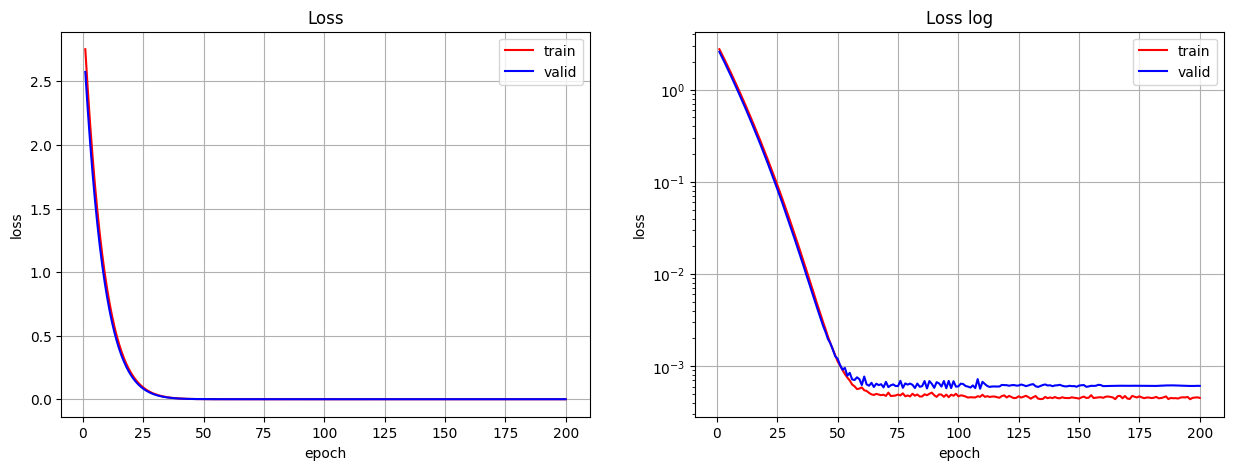

In [12]:
model_dnn = Sequential((
    Flatten(input_shape=x_train.shape[1:]),
    Dense(16, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(model_dnn, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

In [13]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [14]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [15]:
total_returns_model_dnn, cum_total_returns_model_dnn = calculate_returns_for_model(
    model_dnn, x_test, dates_for_test, df_returns_test, selected_countries)

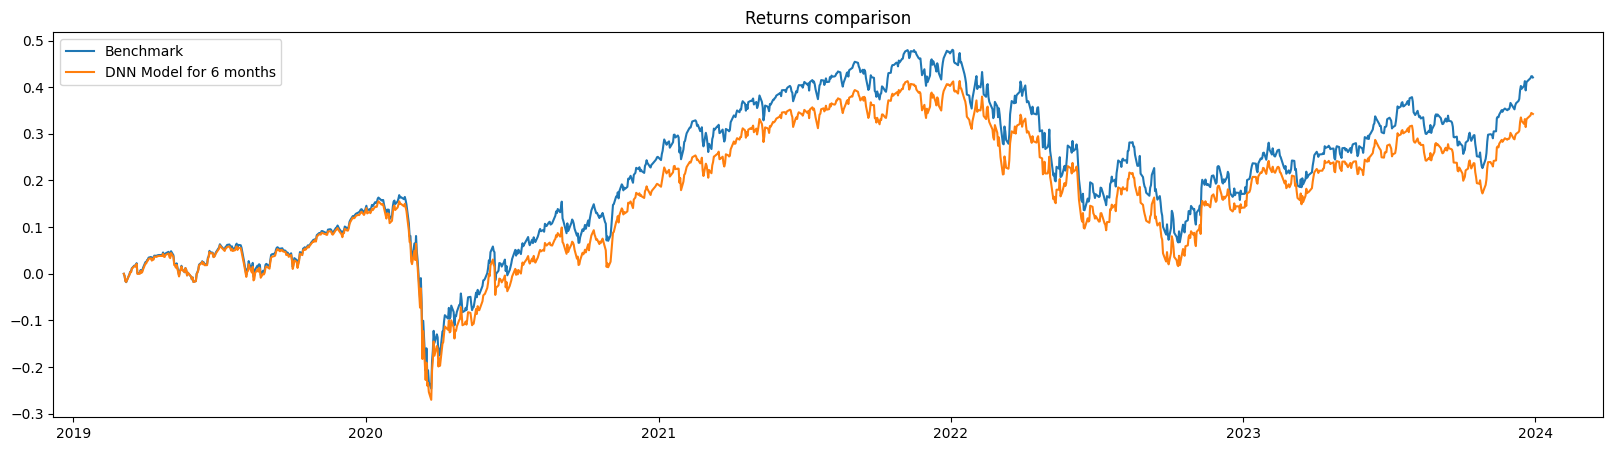

In [16]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_model_dnn,
         label=f'DNN Model for {best_month_no} months')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [17]:
df_results = pd.DataFrame(columns=['Annual Returns',
                                   'Annual Volatility',
                                   'Annual Sharpe Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_model_dnn, df_results,
                  f'DNN Model for {best_month_no} months')
df_results

,Annual Returns,Annual Volatility,Annual Sharpe Ratio
Benchmark,0.076754,0.203326,0.377494
DNN Model for 6 months,0.063038,0.201574,0.31273
